In [12]:
"""
Deepfake Detection Training - Multi-Input CNN (Generator Version)
Load data on-the-fly để tránh RAM đầy
"""
import numpy as np
import os
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [13]:
# ============================================================
# GPU MEMORY CONFIGURATION
# ============================================================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU Memory Growth enabled for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(e)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU available: []


In [14]:
# ============================================================
# PATHS & FILE LISTS
# ============================================================
FAKE_FREQ_DIR = "/Applications/Tien/deepfake/Dataset/features/fake/frequency"
FAKE_MOBILE_DIR = "/Applications/Tien/deepfake/Dataset/features/fake/mobilenet"
REAL_FREQ_DIR = "/Applications/Tien/deepfake/Dataset/features/real/frequency"
REAL_MOBILE_DIR = "/Applications/Tien/deepfake/Dataset/features/real/mobilenet"

print("Scanning files...")
fake_files = sorted([f for f in os.listdir(FAKE_FREQ_DIR) if f.endswith('.npy')])
real_files = sorted([f for f in os.listdir(REAL_FREQ_DIR) if f.endswith('.npy')])

print(f"Found {len(fake_files)} fake samples")
print(f"Found {len(real_files)} real samples")

# Create file lists with labels
file_list = []
for f in fake_files:
    file_list.append((f, 1))  # fake = 1
for f in real_files:
    file_list.append((f, 0))  # real = 0

print(f"Total: {len(file_list)} samples")

# Split into train/val/test
from sklearn.model_selection import train_test_split
train_files, test_files = train_test_split(file_list, test_size=0.2, random_state=42, 
                                            stratify=[label for _, label in file_list])
train_files, val_files = train_test_split(train_files, test_size=0.2, random_state=42,
                                          stratify=[label for _, label in train_files])

print(f"\nTrain: {len(train_files)} samples")
print(f"Val:   {len(val_files)} samples")
print(f"Test:  {len(test_files)} samples")

Scanning files...
Found 16201 fake samples
Found 16171 real samples
Total: 32372 samples

Train: 20717 samples
Val:   5180 samples
Test:  6475 samples


In [15]:
# ============================================================
# DATA GENERATOR FUNCTION
# ============================================================
def data_generator(file_list, batch_size=16, shuffle=True):
    """Generator function to load data batch by batch"""
    indexes = np.arange(len(file_list))
    
    while True:
        if shuffle:
            np.random.shuffle(indexes)
        
        for start_idx in range(0, len(file_list), batch_size):
            end_idx = min(start_idx + batch_size, len(file_list))
            batch_indexes = indexes[start_idx:end_idx]
            
            # Load batch data
            X_freq_batch = []
            X_mobile_batch = []
            y_batch = []
            
            for idx in batch_indexes:
                filename, label = file_list[idx]
                
                # Determine directories based on label
                if label == 1:  # fake
                    freq_dir = FAKE_FREQ_DIR
                    mobile_dir = FAKE_MOBILE_DIR
                else:  # real
                    freq_dir = REAL_FREQ_DIR
                    mobile_dir = REAL_MOBILE_DIR
                
                # Load files
                freq = np.load(os.path.join(freq_dir, filename))
                mobile = np.load(os.path.join(mobile_dir, filename))
                
                X_freq_batch.append(freq)
                X_mobile_batch.append(mobile)
                y_batch.append(label)
            
            X_freq_batch = np.array(X_freq_batch, dtype=np.float32)
            X_mobile_batch = np.array(X_mobile_batch, dtype=np.float32)
            y_batch = np.array(y_batch, dtype=np.float32)
            
            yield (X_freq_batch, X_mobile_batch), y_batch

# Create datasets
BATCH_SIZE = 16

# Calculate steps per epoch
steps_per_epoch = int(np.ceil(len(train_files) / BATCH_SIZE))
validation_steps = int(np.ceil(len(val_files) / BATCH_SIZE))

# Create TF datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_files, BATCH_SIZE, shuffle=True),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 224, 224, 32), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 1280), dtype=tf.float32)
        ),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_files, BATCH_SIZE, shuffle=False),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 224, 224, 32), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 1280), dtype=tf.float32)
        ),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

print(f"\nDatasets created with batch_size={BATCH_SIZE}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")


Datasets created with batch_size=16
Steps per epoch: 1295
Validation steps: 324


In [16]:
# ============================================================
# BUILD MODEL
# ============================================================
print("\nBuilding model...")
# Input layers
input_freq = Input(shape=(224, 224, 32), name='frequency_input')
input_mobile = Input(shape=(1280,), name='mobilenet_input')

# Frequency CNN branch
x1 = Conv2D(32, (3,3), activation='relu', padding='same')(input_freq)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D((2,2))(x1)
x1 = Dropout(0.2)(x1)

x1 = Conv2D(64, (3,3), activation='relu', padding='same')(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D((2,2))(x1)
x1 = Dropout(0.2)(x1)

x1 = Conv2D(128, (3,3), activation='relu', padding='same')(x1)
x1 = BatchNormalization()(x1)
x1 = GlobalAveragePooling2D()(x1)

x1 = Dense(64, activation='relu')(x1)
x1 = Dropout(0.3)(x1)

# MobileNet FC branch
x2 = Dense(256, activation='relu')(input_mobile)
x2 = Dropout(0.3)(x2)
x2 = Dense(64, activation='relu')(x2)
x2 = Dropout(0.3)(x2)

# Concatenate
merged = concatenate([x1, x2], name='fusion')

# Classification head
x = Dense(64, activation='relu')(merged)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=[input_freq, input_mobile], outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Building model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ frequency_input     │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 224, 224,  │      9,248 │ frequency_input[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 112, 112,  │          0 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 112, 112,  │     18,496 │ dropout_6[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 56, 56,    │          0 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │     73,856 │ dropout_7[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenet_input     │ (None, 1280)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │    327,936 │ mobilenet_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │     16,448 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 465,505 (1.78 MB)

 Trainable params: 465,057 (1.77 MB)

 Non-trainable params: 448 (1.75 KB)

In [17]:
# ============================================================
# TRAIN MODEL
# ============================================================
print("\nTraining model...")
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1,
        min_lr=1e-7
    )
]

history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)



Training model...
Epoch 1/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.5705 - loss: 0.6694
Epoch 1: val_accuracy improved from None to 0.72162, saving model to best_model.keras
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 621s 478ms/step - accuracy: 0.6377 - loss: 0.6281 - val_accuracy: 0.7216 - val_loss: 0.5437 - learning_rate: 0.0010
Epoch 2/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.7360 - loss: 0.5394
Epoch 2: val_accuracy improved from 0.72162 to 0.75347, saving model to best_model.keras
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 716s 553ms/step - accuracy: 0.7456 - loss: 0.5219 - val_accuracy: 0.7535 - val_loss: 0.4924 - learning_rate: 0.0010
Epoch 3/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.7792 - loss: 0.4681
Epoch 3: val_accuracy did not improve from 0.75347
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 708s 546ms/step - accuracy: 0.7862 - loss: 0.4567 - val_accuracy: 0.6934 - val_loss: 0.6508 - learning_rate: 0.0010
Epoch 4/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 0s

In [19]:
# ============================================================
# EVALUATE
# ============================================================
print("\nEvaluating model...")

# Tạo test dataset (giống train/val)
test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(test_files, BATCH_SIZE, shuffle=False),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 224, 224, 32), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 1280), dtype=tf.float32)
        ),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

test_steps = int(np.ceil(len(test_files) / BATCH_SIZE))
test_loss, test_acc = model.evaluate(test_dataset, steps=test_steps)

print(f"\n{'='*60}")
print(f"FINAL RESULTS")
print(f"{'='*60}")
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"{'='*60}")

# Predictions
print("\nGenerating predictions...")
y_pred_proba = model.predict(test_dataset, steps=test_steps)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Get true labels
y_test = []
for _, label in test_files:
    y_test.append(label)
y_test = np.array(y_test)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Evaluating model...
405/405 ━━━━━━━━━━━━━━━━━━━━ 36s 88ms/step - accuracy: 0.9436 - loss: 0.1792

FINAL RESULTS
Test Loss:     0.1792
Test Accuracy: 94.36%

Generating predictions...
405/405 ━━━━━━━━━━━━━━━━━━━━ 39s 96ms/step

Classification Report:
              precision    recall  f1-score   support

        Real       0.94      0.95      0.94      3234
        Fake       0.95      0.94      0.94      3241

    accuracy                           0.94      6475
   macro avg       0.94      0.94      0.94      6475
weighted avg       0.94      0.94      0.94      6475


Confusion Matrix:
[[3067  167]
 [ 198 3043]]



Generating visualizations...


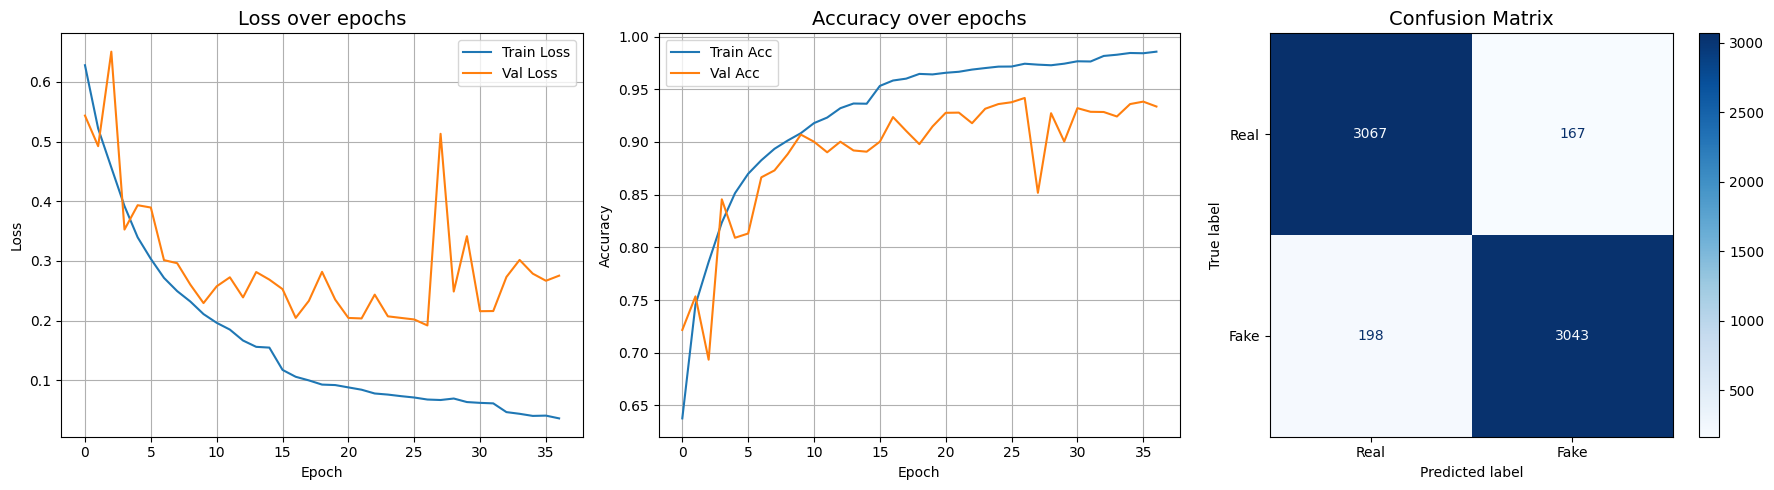


Results saved to: training_results.png


In [20]:
# ============================================================
# VISUALIZE RESULTS
# ============================================================
print("\nGenerating visualizations...")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('Loss over epochs', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Acc')
axes[1].plot(history.history['val_accuracy'], label='Val Acc')
axes[1].set_title('Accuracy over epochs', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
disp.plot(cmap='Blues', ax=axes[2])
axes[2].set_title('Confusion Matrix', fontsize=14)

plt.tight_layout()
plt.savefig('training_results.png', dpi=150)
plt.show()

print("\nResults saved to: training_results.png")



Generating sample predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


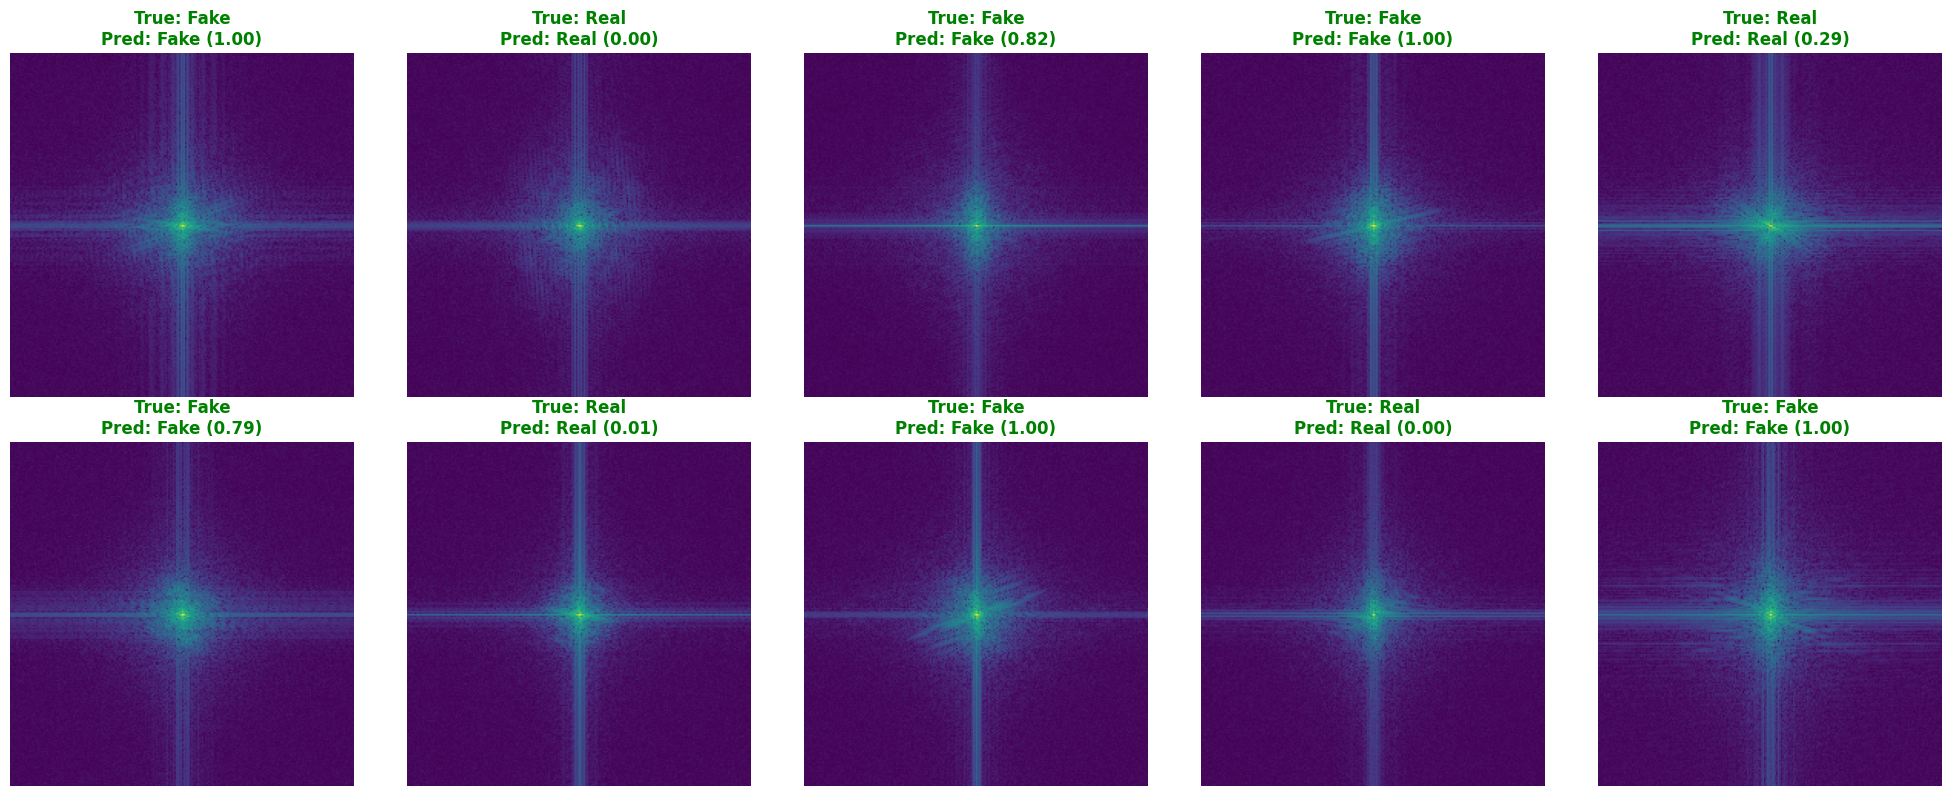

Predictions saved to: sample_predictions.png


In [21]:
# ============================================================
# SAMPLE PREDICTIONS VISUALIZATION
# ============================================================
print("\nGenerating sample predictions...")
# Load first batch for visualization
sample_batch = test_gen[0]
X_freq_sample = sample_batch[0][0][:10]
X_mobile_sample = sample_batch[0][1][:10]
y_sample = sample_batch[1][:10]

# Predict
y_pred_sample = model.predict([X_freq_sample, X_mobile_sample])

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i in range(min(10, len(X_freq_sample))):
    ax = axes[i // 5, i % 5]
    
    # Show FFT channel
    freq_img = X_freq_sample[i][:, :, 0]
    ax.imshow(freq_img, cmap='viridis')
    
    # Prediction
    pred_prob = y_pred_sample[i][0]
    true_label = "Fake" if y_sample[i] == 1 else "Real"
    pred_label = "Fake" if pred_prob > 0.5 else "Real"
    
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f"True: {true_label}\nPred: {pred_label} ({pred_prob:.2f})", 
                 color=color, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=150)
plt.show()

print("Predictions saved to: sample_predictions.png")


In [22]:
# ============================================================
# SAVE MODEL
# ============================================================
print("\nSaving model...")
model.save('deepfake_detection_model.keras')
print("Model saved: deepfake_detection_model.keras")

model_size = os.path.getsize('deepfake_detection_model.keras') / 1024 / 1024
print(f"Model size: {model_size:.2f} MB")

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)


Saving model...
Model saved: deepfake_detection_model.keras
Model size: 5.42 MB

TRAINING COMPLETE!
